# *Working with Missing Data*

### Introduction

In [1]:
import pandas as pd
mvc = pd.read_csv('nypd_mvc_2018.csv')

mvc.head()

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,...,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
1,3847947,2018-02-13,14:45,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,62 STREET,NaN,0,0,...,SPORT UTILITY / STATION WAGON,DS,NaN,NaN,NaN,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,3914294,2018-06-04,0:00,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN,0,0,...,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN
3,3915069,2018-06-05,6:36,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,VANLOON STREET,NaN,0,0,...,Sedan,Sedan,NaN,NaN,NaN,Glare,Passing Too Closely,NaN,NaN,NaN
4,3923123,2018-06-16,15:45,BRONX,"(40.884727, -73.89945)",NaN,NaN,208 WEST 238 STREET,0,0,...,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,Turning Improperly,Unspecified,NaN,NaN,NaN


In [2]:
null_counts = mvc.isnull().sum()
null_counts.head()

unique_key        0
date              0
time              0
borough       20646
location       3885
dtype: int64

### Verifying the Total Columns

In [3]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

killed_manual_sum = killed.iloc[:, :3].sum(axis=1)
killed_mask = (killed_manual_sum != killed['total_killed'])
killed_non_eq = killed[killed_mask]
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


### Filling and Verifying the Killed and Injured Data

In [4]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)
injured['total_injured'].head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: total_injured, dtype: float64

### Assigning the corrected data back to the main dataframe

In [6]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

mvc[['total_killed', 'total_injured']].isnull().sum()

total_killed      1
total_injured    21
dtype: int64

### Visualizing missing data with Plots

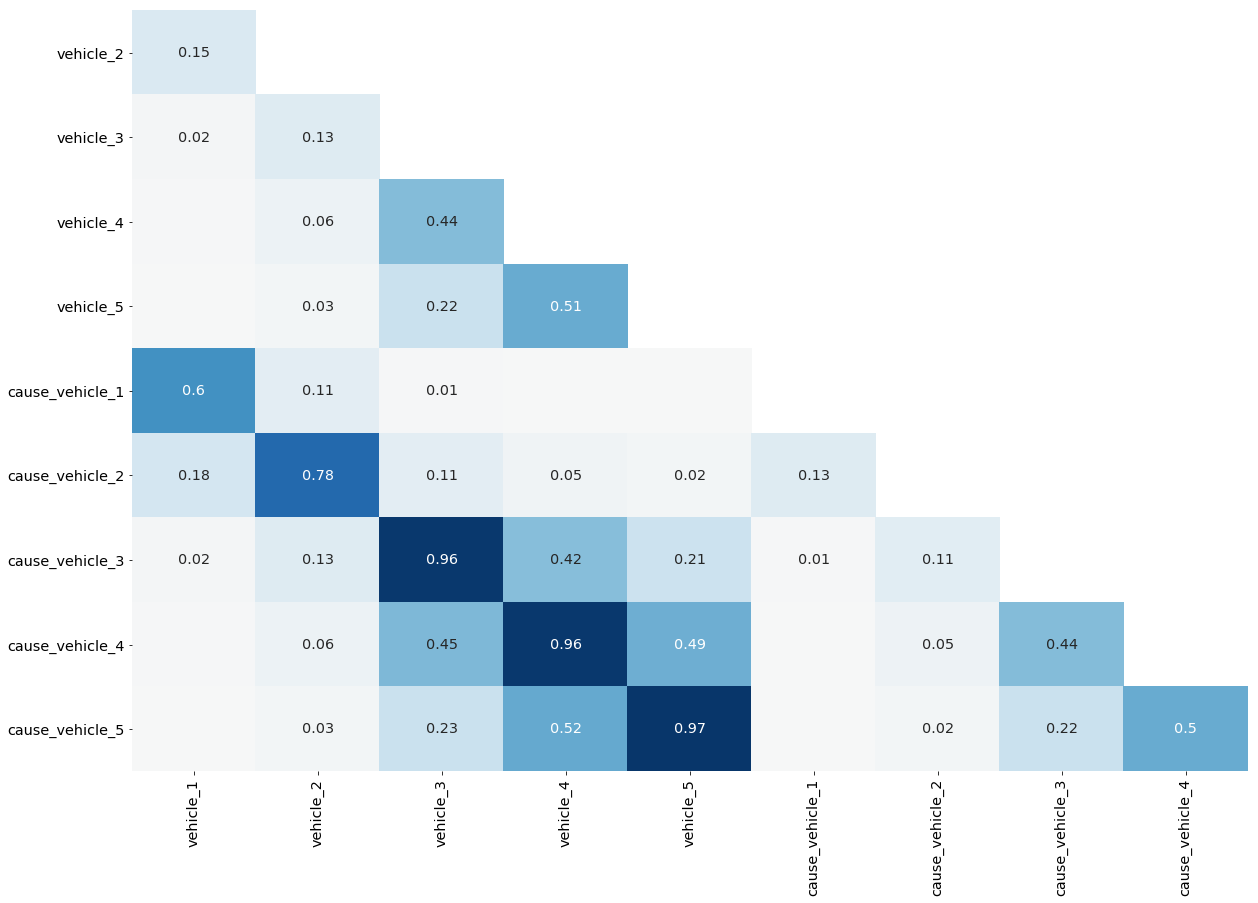

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it eaiser to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
vehicle_cols = [i for i in mvc.columns if 'vehicle' in i]
plot_null_correlations(mvc[vehicle_cols])

### Analyzing Correlations in Missing Data

In [14]:
col_labels = columns=['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null =  mvc[mvc[v_col].isnull() & ~mvc[c_col].isnull()].shape[0]
    c_null = mvc[~mvc[v_col].isnull() & mvc[c_col].isnull()].shape[0]
    
    vc_null_data.append([v, v_null, c_null])
    
vc_null_df = pd.DataFrame(vc_null_data, columns=col_labels)
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


### Finding the Most Common Values Across Multiple Columns

In [18]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

v_df = mvc[v_cols]
v_1d = v_df.stack()
top10_vehicles = v_1d.value_counts().head(10)
top10_vehicles

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
dtype: int64

### Filling Unknown Values with a Placeholder

In [19]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    # create a mask for each column
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()

    # replace the values matching the mask for each column
    mvc[v_col] =  mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] =  mvc[c_col].mask(c_missing_mask, "Unspecified")
    
summary_after = summarize_missing()

print(summary_before)
summary_after

   vehicle_number  vehicle_missing  cause_missing
0               1              204             24
1               2             3793            223
2               3              242             24
3               4               50              3
4               5               10              0


,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0
